In [1]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt

In [3]:
from prophet import Prophet
import pandas as pd

# load data into a dataframe
gas_prices_df = pd.read_excel("gaspricebls.xlsx")

#group the data by year and calculate the mean of each group
#df_mean = gas_prices_df.groupby(gas_prices_df.columns.str[0], axis=1).mean()
#print(gas_prices_df.head())

gas_prices_df.columns = gas_prices_df.columns[[0]].tolist() + list(range(1,13))
s = gas_prices_df.melt('Year')
s['Year-month'] = s[['Year','variable']].astype(str).agg('-'.join, 1)

# remove year-month column and sort it by year
s = s.drop(['Year-month'], axis=1)
s = s.sort_values(by=['Year', 'variable'])
s["Year-month"] = s['Year'].astype(str) +"-"+ s["variable"].astype(str)
s = s.drop(['Year', 'variable'], axis=1)

df_mean = s
df_mean

,value,Year-month
0,0.605,1976-1
47,0.600,1976-2
94,0.594,1976-3
141,0.592,1976-4
188,0.600,1976-5
...,...,...
375,4.101,2022-8
422,3.881,2022-9
469,4.016,2022-10
516,3.853,2022-11


In [4]:
# aggregate year and variable

#rename the columns
df_mean.columns = ["GasPrice", "YearMonth"]

# rename columns to match prophet's expected format
gas_prices_df = df_mean.rename(columns={'YearMonth': 'ds', 'GasPrice': 'y'})
gas_prices_df = gas_prices_df.drop(gas_prices_df.index[:2])
gas_prices_df = gas_prices_df.drop(gas_prices_df.index[:39])
gas_prices_df = gas_prices_df.drop(gas_prices_df.index[-12:]) #-1 for 21, -3 for 19
print(gas_prices_df.info())

#gas_prices_df['ds'] = pd.to_datetime(gas_prices_df['ds'], format='%Y').dt.to_period('Y')
#gas_prices_df['ds'] = pd.to_datetime(gas_prices_df['ds'], format='%Y')
#gas_prices_df['ds'] = pd.DatetimeIndex(gas_prices_df['ds'].to_timestamp())
#print(gas_prices_df.info())
# format the 'ds' column to display as "Jan 1, 1976"
#gas_prices_df['ds'] = gas_prices_df['ds'].dt.strftime('%b %d, %Y')
#gas_prices_df.dtypes

gas_prices_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511 entries, 238 to 562
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       511 non-null    float64
 1   ds      511 non-null    object 
dtypes: float64(1), object(1)
memory usage: 12.0+ KB
None


,y,ds
238,0.901,1979-6
285,0.949,1979-7
332,0.988,1979-8
379,1.020,1979-9
426,1.028,1979-10
...,...,...
374,3.255,2021-8
421,3.265,2021-9
468,3.385,2021-10
515,3.482,2021-11


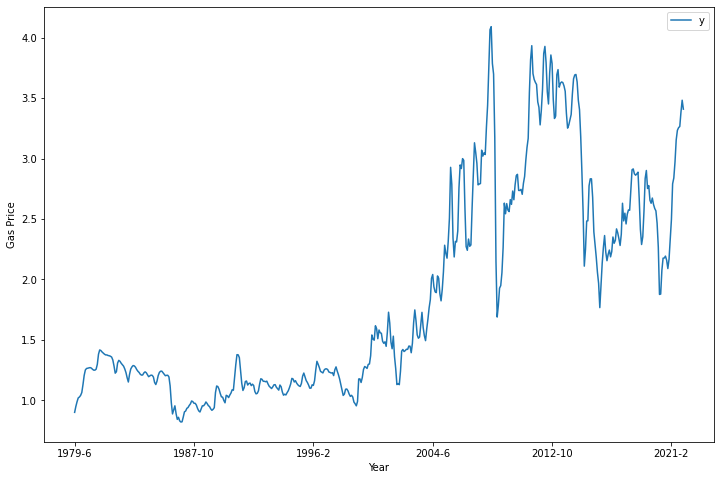

In [5]:
ax = gas_prices_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Gas Price')
ax.set_xlabel('Year')

plt.show()

In [6]:
# create a prophet model
model = Prophet(interval_width=0.95)

print(gas_prices_df)
# fit the model to the data
model.fit(gas_prices_df)

# create a dataframe to hold the predictions
future = model.make_future_dataframe(periods=12, freq='M')
future.tail()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp38_clr7i/v121j3t9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp38_clr7i/y8csz04i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67174', 'data', 'file=/tmp/tmp38_clr7i/v121j3t9.json', 'init=/tmp/tmp38_clr7i/y8csz04i.json', 'output', 'file=/tmp/tmp38_clr7i/prophet_modelt5ubs808/prophet_model-20230129054702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


         y       ds
238  0.901   1979-6
285  0.949   1979-7
332  0.988   1979-8
379  1.020   1979-9
426  1.028  1979-10
..     ...      ...
374  3.255   2021-8
421  3.265   2021-9
468  3.385  2021-10
515  3.482  2021-11
562  3.408  2021-12

[511 rows x 2 columns]


05:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
518,2022-07-31
519,2022-08-31
520,2022-09-30
521,2022-10-31
522,2022-11-30


In [7]:
# make predictions
predictions = model.predict(future)

# view the predictions for the year 2022
print("pred:", predictions[['ds', 'yhat']])#.dt.year == 2022)

pred:             ds      yhat
0   1979-06-01  1.264988
1   1979-07-01  1.269755
2   1979-08-01  1.257650
3   1979-09-01  1.230034
4   1979-10-01  1.185485
..         ...       ...
518 2022-07-31  2.455894
519 2022-08-31  2.365441
520 2022-09-30  2.323730
521 2022-10-31  2.401874
522 2022-11-30  2.340454

[523 rows x 2 columns]


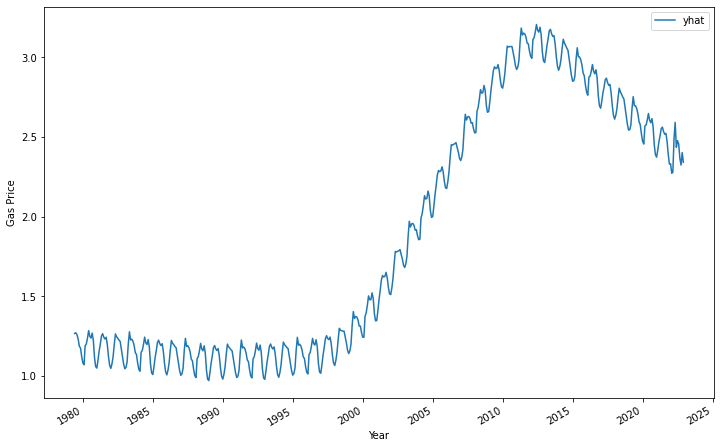

In [8]:
ax = predictions[['ds', 'yhat']].set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Gas Price')
ax.set_xlabel('Year')

plt.show()

In [10]:
signal = predictions[['yhat']].to_numpy().T[0]
signal

gas_signal = gas_prices_df[['y']].to_numpy().T[0]
gas_signal

array([0.901, 0.949, 0.988, 1.02 , 1.028, 1.041, 1.065, 1.131, 1.207,
       1.252, 1.264, 1.266, 1.269, 1.271, 1.267, 1.257, 1.25 , 1.25 ,
       1.258, 1.298, 1.382, 1.417, 1.412, 1.4  , 1.391, 1.382, 1.376,
       1.376, 1.371, 1.369, 1.365, 1.358, 1.334, 1.284, 1.225, 1.237,
       1.309, 1.331, 1.323, 1.307, 1.295, 1.283, 1.26 , 1.23 , 1.187,
       1.152, 1.215, 1.259, 1.277, 1.288, 1.285, 1.274, 1.255, 1.241,
       1.231, 1.216, 1.209, 1.21 , 1.227, 1.236, 1.229, 1.212, 1.196,
       1.203, 1.209, 1.207, 1.193, 1.148, 1.131, 1.159, 1.205, 1.231,
       1.241, 1.242, 1.229, 1.216, 1.204, 1.207, 1.208, 1.194, 1.12 ,
       0.981, 0.888, 0.923, 0.955, 0.89 , 0.843, 0.86 , 0.831, 0.821,
       0.823, 0.862, 0.905, 0.912, 0.934, 0.941, 0.958, 0.971, 0.995,
       0.99 , 0.976, 0.976, 0.961, 0.933, 0.913, 0.904, 0.93 , 0.955,
       0.955, 0.967, 0.987, 0.974, 0.957, 0.949, 0.93 , 0.918, 0.926,
       0.94 , 1.065, 1.119, 1.114, 1.092, 1.057, 1.029, 1.027, 0.999,
       0.98 , 1.042,

In [11]:
print(signal.shape)

(523,)


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


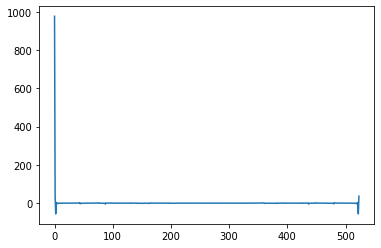

In [12]:
import scipy.fft
import numpy as np

fouriersignal = scipy.fft.fft(signal)
plt.plot(np.linspace(0, signal.shape[0], 523), fouriersignal)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


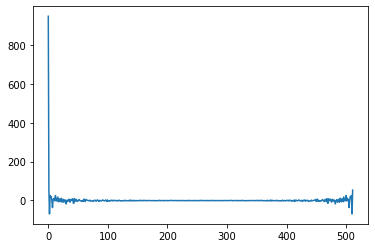

In [13]:
gas_fouriersignal = scipy.fft.fft(gas_signal)
plt.plot(np.linspace(0, gas_signal.shape[0], 511), gas_fouriersignal)

In [128]:
# want to try emd, subtract the ones that fourier alr captures, forecast the residual and then add it to the forecast

In [14]:
!pip install EMD-signal
from PyEMD import EMD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 7.8 MB/s eta 0:00:00


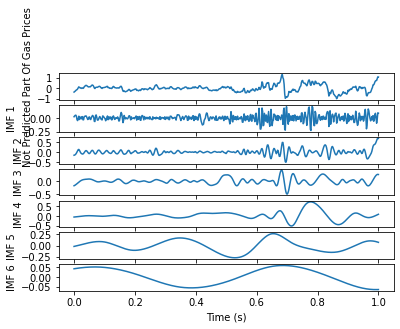

In [25]:
# Create a time vector for the square wave and define the period, amplitude, and duty cycle of the square wave
t = np.linspace(0, 1, gas_signal.shape[0])  # time vector

# Perform the EMD on the square wave signal. You can use the EMD function from the PyEMD package to perform the EMD in Python.
emd = EMD()
diff_signal = gas_signal-signal[:511]
imfs = emd(diff_signal)

# Plot the IMFs using Matplotlib
fig, axs = plt.subplots(len(imfs), 1, sharex=True)

# Plot the square wave
axs[0].plot(t, diff_signal)
axs[0].set_ylabel("Not Predicted Part Of Gas Prices")



for i, ax in enumerate(axs[1:]):
    ax.plot(t, imfs[i])
    ax.set_ylabel("IMF {}".format(i+1))

axs[-1].set_xlabel("Time (s)")

plt.show()


Test EMD for Gas Prices with pyEMD

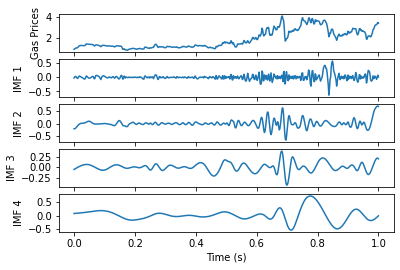

In [33]:
# Create a time vector for the square wave and define the period, amplitude, and duty cycle of the square wave
t = np.linspace(0, 1, gas_signal.shape[0])  # time vector

# Perform the EMD on the square wave signal. You can use the EMD function from the PyEMD package to perform the EMD in Python.
emd = EMD()
#diff_signal = gas_signal-signal[:511]
imfs = emd(gas_signal)

# Plot the IMFs using Matplotlib
fig, axs = plt.subplots(len(imfs), 1, sharex=True)

# Plot the square wave
axs[0].plot(t, gas_signal)
axs[0].set_ylabel("Gas Prices")



for i, ax in enumerate(axs[1:]):
    ax.plot(t, imfs[i])
    ax.set_ylabel("IMF {}".format(i+1))

axs[-1].set_xlabel("Time (s)")

plt.show()


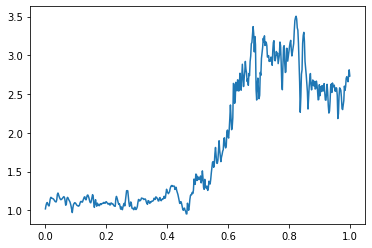

In [31]:
# grab IMFs 3, 4, 5, 6 and then sum plot
trend = sum([imfs[i] for i in [0, 2, 4]])
plt.plot(t, trend)

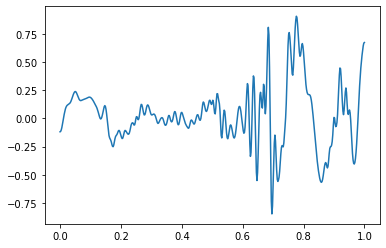

In [32]:
plt.plot(t, gas_signal-trend)

EMD with emd library

In [35]:
!pip install emd
import emd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


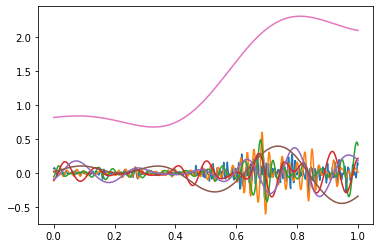

In [80]:
# do EMD for hilbert spectrum
imf = emd.sift.mask_sift(gas_signal, max_imfs=7)
plt.plot(t, imf)

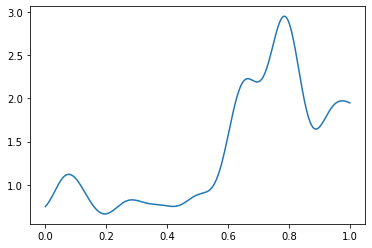

In [81]:
gas_trend = sum(imf.T[-3:])
plt.plot(t, gas_trend) # trend

            y       ds
238  0.749063   1979-6
285  0.756207   1979-7
332  0.764163   1979-8
379  0.772876   1979-9
426  0.782293  1979-10
..        ...      ...
374  1.960218   2021-8
421  1.957539   2021-9
468  1.954637  2021-10
515  1.951521  2021-11
562  1.948200  2021-12

[511 rows x 2 columns]
pred:             ds      yhat
0   1979-06-01  0.984186
1   1979-07-01  0.986459
2   1979-08-01  0.988134
3   1979-09-01  0.990002
4   1979-10-01  0.990096
..         ...       ...
518 2022-07-31  1.550064
519 2022-08-31  1.549892
520 2022-09-30  1.544103
521 2022-10-31  1.531347
522 2022-11-30  1.514268

[523 rows x 2 columns]


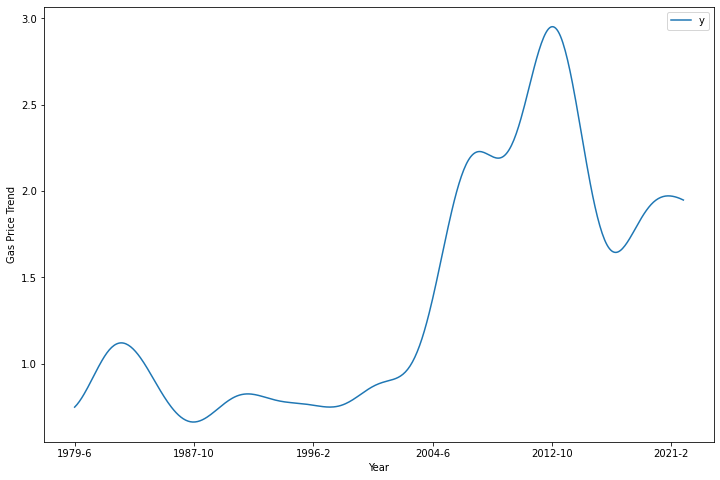

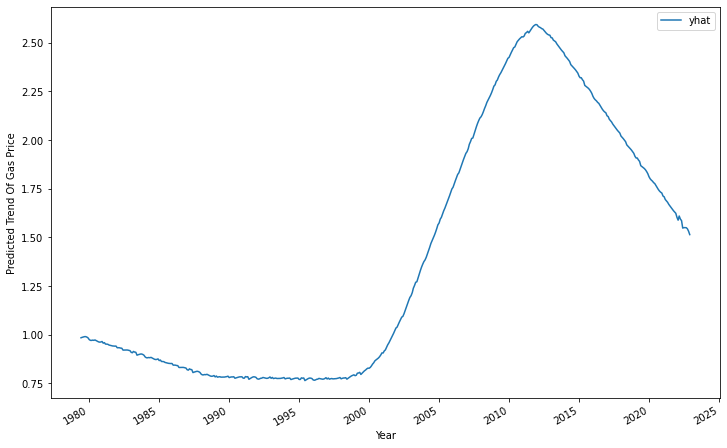

In [101]:
# plot
gas_prices2 = gas_prices_df.copy()
gas_prices2['y'] = gas_trend
ax = gas_prices2.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Gas Price Trend')
ax.set_xlabel('Year')

# prophet on this

# create a prophet model
model = Prophet(interval_width=0.7)#, yearly_seasonality=0)

print(gas_prices2)
# fit the model to the data
model.fit(gas_prices2)

# create a dataframe to hold the predictions
future = model.make_future_dataframe(periods=12, freq='M')
future.tail()

# make predictions
predictions = model.predict(future)

# view the predictions for the year 2022
print("pred:", predictions[['ds', 'yhat']])#.dt.year == 2022)

ax = predictions[['ds', 'yhat']].set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Predicted Trend Of Gas Price')
ax.set_xlabel('Year')

plt.show()

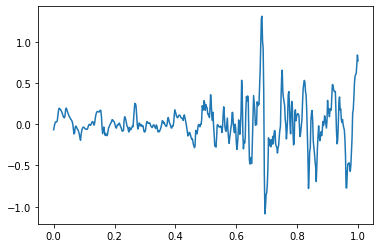

In [52]:
plt.plot(t, sum(imf.T[:-3])) # fluctuations

More Data Processing

In [131]:
sample_df = predictions[['ds']].drop(predictions[['ds']].index[511:]).to_numpy()

arr1 = np.array([diff_signal])[0]
arr2 = sample_df.T[0]
print(arr1.shape)
print(arr2.shape)

labels = np.array(range(511))

data = {'index:':labels, 'y': arr1, 'ds': arr2}

# Create the DataFrame
sample_df = pd.DataFrame.from_dict(data, orient='index')
sample_df = pd.DataFrame(sample_df.to_numpy().T)

sample_df = sample_df.rename(columns={2: 'ds', 1: 'y'})
sample_df = sample_df.drop(sample_df[[0]], axis=1)

sample_df

(511,)
(511,)


,y,ds
0,-0.363988,1979-06-01
1,-0.320755,1979-07-01
2,-0.26965,1979-08-01
3,-0.210034,1979-09-01
4,-0.157485,1979-10-01
...,...,...
506,0.737744,2021-08-01
507,0.74199,2021-09-01
508,0.913667,2021-10-01
509,1.092415,2021-11-01


In [132]:
diff_model = Prophet(interval_width=0.95)

# fit the model to the data
diff_model.fit(sample_df)

# create a dataframe to hold the predictions
diff_future = diff_model.make_future_dataframe(periods=12, freq='M')
diff_future.tail()

# make predictions
diff_predictions = diff_model.predict(diff_future)

# view the predictions for the year 2022
print("pred:", diff_predictions[['ds', 'yhat']])#.dt.year == 2022)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp45g3v1lt/edf79j4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp45g3v1lt/0qcwgpbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83545', 'data', 'file=/tmp/tmp45g3v1lt/edf79j4k.json', 'init=/tmp/tmp45g3v1lt/0qcwgpbn.json', 'output', 'file=/tmp/tmp45g3v1lt/prophet_modelmk5akel9/prophet_model-20230129012945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:29:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:29:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


pred:             ds      yhat
0   1979-06-01  0.005133
1   1979-07-01  0.005283
2   1979-08-01  0.004711
3   1979-09-01  0.004436
4   1979-10-01  0.005146
..         ...       ...
518 2022-07-31 -0.006821
519 2022-08-31 -0.007556
520 2022-09-30 -0.005437
521 2022-10-31 -0.007737
522 2022-11-30 -0.005250

[523 rows x 2 columns]


(523,)
(523,)
            y         ds
0     1.27012 1979-06-01
1    1.275038 1979-07-01
2    1.262361 1979-08-01
3     1.23447 1979-09-01
4    1.190631 1979-10-01
..        ...        ...
518  2.449073 2022-07-31
519  2.357885 2022-08-31
520  2.318293 2022-09-30
521  2.394137 2022-10-31
522  2.335204 2022-11-30

[523 rows x 2 columns]


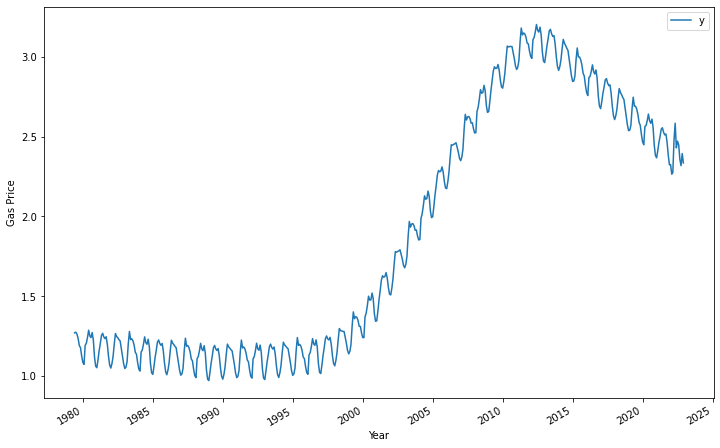

In [133]:
sum_pred = diff_predictions[['yhat']].to_numpy().T[0] + predictions[['yhat']].to_numpy().T[0]

# aosidhaisudh


ds = predictions[['ds']].to_numpy().T[0]

print(ds.shape)
print(sum_pred.shape)

labels = np.array(range(511))

data = {'index:':labels, 'y': sum_pred, 'ds': ds}

# Create the DataFrame
sum_df = pd.DataFrame.from_dict(data, orient='index')
sum_df = pd.DataFrame(sum_df.to_numpy().T)

sum_df = sum_df.rename(columns={2: 'ds', 1: 'y'})
sum_df = sum_df.drop(sum_df[[0]], axis=1)

print(sum_df)

# aisudhaisudhas

ax = sum_df[['ds', 'y']].set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Gas Price')
ax.set_xlabel('Year')

plt.show()

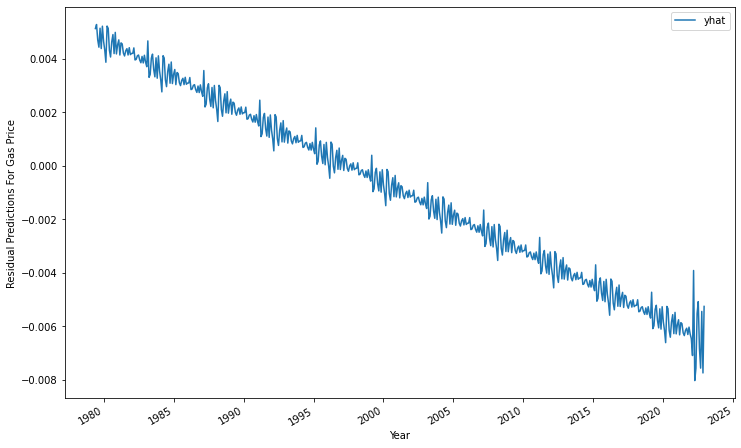

In [134]:
ax = diff_predictions[['ds', 'yhat']].set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Residual Predictions For Gas Price')
ax.set_xlabel('Year')

plt.show()
# normalize visually later

Models

In [56]:
# Load the data from the Excel file
data = pd.read_csv('transformed_data.csv')
test_data = pd.read_csv('transformed_2020_data.csv')

# Split the data into features (X) and labels (y)
cols_to_use = data.columns.difference(['TotalAmountofAssistance', 'StateCode'])
#cols_to_use = ['CO2 Emissions (Mmt)', 'TotalNumberofInvestments', 'GETCB', 'HYTCB','NCPRB', 'NUETB', 'REPRB']
X = data[cols_to_use]
y = data['TotalAmountofAssistance'] # replace label with the actual name of the column you want to use as the label

In [ ]:
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Create a polynomial SVM model
poly_svm = svm.SVR(kernel='linear', degree=7, max_iter=1e6)

test_X = test_data[cols_to_use]
test_y = test_data['TotalAmountofAssistance'] # replace label with the actual name of the column you want to use as the label

# Initialize the recursive feature eliminator
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)

# Fit the model to the data
#poly_svm.fit(X, y)

# Fit the model with RFE
rfe.fit(X, y)

# Print the features that were selected
print(rfe.support_)

#print(np.sqrt(sum(np.abs(test_y-poly_svm.predict(test_X))**2)/50))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#print(rmse(poly_svm.predict(test_X), test_y))

EMD on some random MSN

 Inputs samples (250) is small for specified max_imfs (7) very likely that 6 or fewer imfs are returned


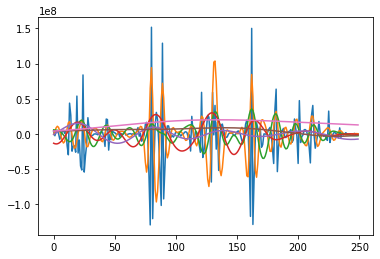

In [60]:
# do EMD for hilbert spectrum
imf = emd.sift.mask_sift(y.to_numpy(), max_imfs=7)
plt.plot(range(250), imf)

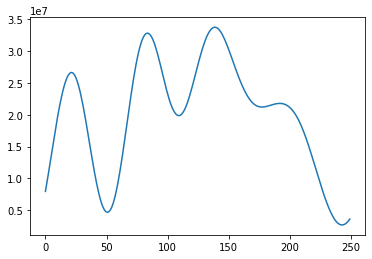

In [72]:
invest_trend = sum(imf.T[-3:])
plt.plot(range(250), invest_trend) # trend

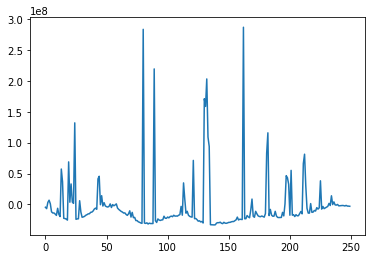

In [71]:
plt.plot(range(250), sum(imf.T[:-3])) # fluctuations in investment
# it's like this because the years are mixed up

Continue inference stuff

In [356]:
def add_gaussian_noise(arr):
    noise = np.random.normal(0, 0.05*np.std(arr, axis=0), arr.shape)
    return arr + noise

In [357]:
X_np = X
y_np = y
for i in range(5):
  X_np = np.vstack((X_np, add_gaussian_noise(X)))
  y_np = np.hstack((y_np, y))
X_np.shape, y_np.shape

((1500, 32), (1500,))

In [228]:
new_cols_to_use = []
for i in range(cols_to_use.shape[0]):
  if rfe.support_[i] == True:
    new_cols_to_use.append(cols_to_use[i])

In [328]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X[new_cols_to_use], y)

print(rmse(rf.predict(test_X[new_cols_to_use]), test_y))
print(rmse(rf.predict(X[new_cols_to_use]), y))

30090697.160304412
15932040.191159874


In [365]:
rf2 = RandomForestRegressor(n_estimators=1000)
rf2.fit(X_np, y_np)

print(rmse(rf2.predict(test_X), test_y))
print(rmse(rf2.predict(X), y))

39584553.62498849
7034901.446850341


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [242]:
# Create a polynomial SVM model
poly_svm = svm.SVR(kernel='poly', degree=3, max_iter=1e6)

# Fit the model to the data
poly_svm.fit(X[new_cols_to_use], y)
print(rmse(poly_svm.predict(test_X[new_cols_to_use]), test_y))
print(rmse(poly_svm.predict(X[new_cols_to_use]), y))

37108239.69306531
47054684.72426003


In [243]:
# Create a polynomial SVM model
poly_svm = svm.SVR(kernel='poly', degree=3, max_iter=1e6)

# Fit the model to the data
poly_svm.fit(X, y)
print(rmse(poly_svm.predict(test_X), test_y))
print(rmse(poly_svm.predict(X), y))

37106856.9827475
47054483.28520132


(250, 16)


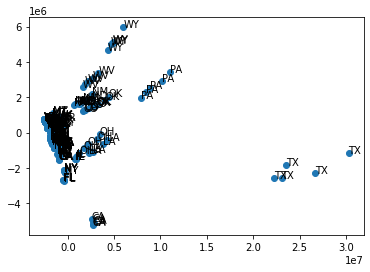

In [369]:
from sklearn.decomposition import PCA

# instantiate the PCA model
pca = PCA(n_components=16)

# fit and transform the data
reduced_data = pca.fit_transform(X)
labels = data['StateCode']

#print the new shape of data
print(reduced_data.shape)

for i, label in enumerate(labels):
    plt.annotate(label, (reduced_data[i, 0], reduced_data[i, 1]))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.show()

In [370]:
# Create a polynomial SVM model
poly_svm = svm.SVR(kernel='poly', degree=3, max_iter=1e6)

# Fit the model to the data
poly_svm.fit(reduced_data, y)

# instantiate the PCA model
pca = PCA(n_components=16)

# fit and transform the data
reduced_test_X = pca.fit_transform(test_X)

print(rmse(poly_svm.predict(reduced_test_X), test_y))
print(rmse(poly_svm.predict(reduced_data), y))

37105989.36981876
47054056.444740206


# Pytorch

In [137]:
print(X.to_numpy(), "haha", y.to_numpy())

[[2.1000e+01 4.0000e+00 2.1000e+01 ... 7.4880e+03 1.4880e+03 2.0150e+03]
 [2.7000e+01 5.0000e+00 2.7000e+01 ... 8.0480e+03 1.5630e+03 2.0160e+03]
 [2.9000e+01 5.0000e+00 2.9000e+01 ... 6.9370e+03 1.3050e+03 2.0170e+03]
 ...
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 5.0490e+03 3.9806e+04 2.0170e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 4.9340e+03 3.6936e+04 2.0180e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 4.9690e+03 3.7070e+04 2.0190e+03]] haha [  3345612   2247734  13509662  18236626  13734021   1864412   1206793
   2414699   1844186    840218  13453887   4637664   2069460  79970512
  60034678   1724853   2053339   1714281    539053  95135122  30077512
  59755992  30392556  28208367 158244985   1658730   1800615   1385451
  29876375  10796826   1340702    962061    788599   1486681   1306178
   1452666    502817   1636426    824222   1485254   3527420   4068360
   1239122  49550089  52936642   6155856  20155611   2884817   7882488
   2374660   1033143    429104   1467132   5818783    

In [138]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.lazylinear = nn.LazyLinear(out_features=1024)
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=7, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, padding=1)
        self.dense = nn.LazyLinear(out_features=2048)
        self.dense2 = nn.LazyLinear(out_features=1024)
        self.dense3 = nn.Linear(in_features=1024, out_features=512)
        self.output = nn.Linear(in_features=512, out_features=256)
        self.last = nn.Linear(in_features=256, out_features=1)

    def forward(self, x):
        x = self.lazylinear(x)
        x = torch.reshape(x, (-1, 16, 8))
        x = torch.selu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        #x = torch.selu(self.conv3(x))
        x = x.flatten(1)
        x = torch.sigmoid(self.dense(x))
        x = torch.sigmoid(self.dense2(x))
        x = torch.relu(self.dense3(x))
        x = torch.sigmoid(self.output(x))
        x = self.last(x)
        return x


In [358]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.lazylinear = nn.LazyLinear(out_features=64)
        self.l1 = nn.LazyLinear(out_features=64)
        self.l2 = nn.LazyLinear(out_features=64)
        self.last = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = torch.selu(self.lazylinear(x))
        x = torch.selu(self.l1(x))
        x = torch.selu(self.l2(x))
        x = torch.relu(self.last(x))
        return x


In [359]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils

# Assuming your data is in the form of a numpy array with shape (num_samples, input_dim)
# and labels in the form of a numpy array with shape (num_samples,)
X_train, y_train = X_np, y_np
y_train = y_train

# Convert data and labels to PyTorch tensors
X_train = torch.from_numpy(X_train).double().cuda()
y_train = torch.from_numpy(y_train).double().cuda()

# Create a TensorDataset to store the data and labels together
train_dataset = TensorDataset(X_train, y_train)

# Create a DataLoader to handle batching the data during training
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [361]:
# Define your model
model = SimpleModel().double().cuda()

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        mse_loss = self.mse(predictions, targets)
        rmse_loss = torch.sqrt(mse_loss)
        return rmse_loss

# Define a loss function and optimizer
criterion = RMSELoss()
optimizer = torch.optim.Adam(lr=1e-100, params=model.parameters())


# Training loop
num_epochs = 9
for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_loader):
        # Forward pass
        output = model(X_batch)
        
        # Compute loss
        loss = criterion(output, y_batch)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass and optimize
        loss.backward()
        #utils.clip_grad_norm_(model.parameters(), 1e-60)
        optimizer.step()
        
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


Epoch 1/9, Loss: 7748635.0396
Epoch 2/9, Loss: 5024086.8518
Epoch 3/9, Loss: 1768028.0363
Epoch 4/9, Loss: 13048349.0383
Epoch 5/9, Loss: 3307768.2353
Epoch 6/9, Loss: 909229.6969
Epoch 7/9, Loss: 11938523.1531
Epoch 8/9, Loss: 2033451.1932
Epoch 9/9, Loss: 1799075.8143


In [362]:
X_ten = torch.tensor(X.to_numpy())
test_X_ten = torch.tensor(test_X.to_numpy())
test_y_ten = test_y.to_numpy()

In [363]:
np.sqrt(sum(np.abs(model.cpu()(test_X_ten.cpu()).detach().numpy()[0]-test_y_ten)**2)/50)

38177142.43081678

In [364]:
np.sqrt(sum(np.abs(model.cpu()(torch.tensor(X.to_numpy()).cpu()).detach().numpy()[0]-y)**2)/50)

106995166.76481827